# Extension to Kuhlen(2016)

In Kuhlen(2016), I use GDP per worker. The reason for using GDP per worker is based on Jones(1996). Jones suggests that GDP per worker reflects incomes for countries in developing countries (Africa) better due to non-market income. 

Additionally, Kuhlen(2016) uses the concept of unweighted inequality. He claims that using population weights would mask the effect of increasing inequality to due population differences in Asian and African countries.

In this paper I investigate the effect of using GDP per capita and population weights on the development of international inequality. 

Additionally, Kuhlen(2016) shows that the income distributions have heavy tails. One way to adjust for this is to use logarithms. However, the standard kde does not perform well in this situation. Based thereon, I show the effect of using logarithms and the adjusted kernel as proposed by Charpentier et al (2014) for applications to income distributions.

## Packages

In [1]:
import pandas as pd
import numpy as np
import pickle

%matplotlib inline
from matplotlib import rc
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../model_code')
from kde import UnivariateKernelDensity

/Applications/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Data

In [2]:
# Read in the csv file.
data_pwt = pd.read_csv('pwt71_wo_country_names_wo_g_vars.csv')

# Exclude official Chinese statistics from data set as corrected data is
# included as 'CH2'
data_pwt = data_pwt[data_pwt['isocode'] != 'CHN']

data = data_pwt[['isocode', 'year', 'rgdpwok', 'POP', 'rgdpch']]

# Restrict data to some specified years.
years = list(range(1970, 2011))
# years = [1970, 1980, 1990, 2000, 2010]
data = data[data['year'].isin(years)].dropna()

# Check which countries have entries for specified the years.
country_duplicates = {}
for country in data['isocode'].unique():
    country_duplicates[country] = (
        list(data['isocode']).count(country) == len(years)
    )

# Create list of the countries with entries for all specified years
countries = []
for country in sorted(country_duplicates.keys()):
    if country_duplicates[country] is True:
        countries.append(country)
    else:
        pass

print(
    'Number of countries with entries for all specified years:', len(countries)
)
# Restrict data to countries for which data is available for the specified
# years.
data = data[(data['isocode'].isin(countries) == True)]

# Calculate percentage of world population which is about 7.4 billion people
# and total numbeulerr of countries in the world which is 195.
pop_incl = sum(data[(data['year'] == 2010)]['POP'])
print('Share of total number of countries:', len(countries) / 195)
print('Percentage of world population:', pop_incl / 7400000)

Number of countries with entries for all specified years: 141
Share of total number of countries: 0.7230769230769231
Percentage of world population: 0.861184840541


## Replication

I first replicate the results obtained by Kuhlen(2016).

### Analysis

In [3]:
# Specify bandwidth selection methods to be used in estimation.
bw_methods = ['lscv', 'silverman']

# Estimate the densities for the different years and bandwidth selection
# methods.
estimated_densities_unweighted = {}

for year in years:
    # Create dictionary entry for year.
    estimated_densities_unweighted[year] = {}

    # Restrict data to specified year.
    data_unweighted_yearly = data[data['year'] == year].rgdpwok

    # Initialise the kernel density estimator.
    kde = UnivariateKernelDensity(data=data_unweighted_yearly)

    for bandwidth in sorted(bw_methods):
        kde(bandwidth, stretch=2.9)

        # Save the estimated density and corresponding support in dictionary
        estimated_densities_unweighted[year][bandwidth] = {
            'support': list(kde.support),
            'density': list(kde.estimated_density)
        }

### Visualisation

In [4]:
# Specify plot parameters.
plot_params = {
    'colour_bw': {'lscv': '#9C9C9C', 'silverman': '#484748'},
    'colour_bw_presentation': {'lscv': 'blue', 'silverman': 'black'},
    'figure_width': 10,
    'figure_height': 7.5,
    'font_size_labels': 28,
    'font_size_legend': 28,
    'font_size_ticks': 30,
    'line_width': 3.5,
    'title_size': 28
}

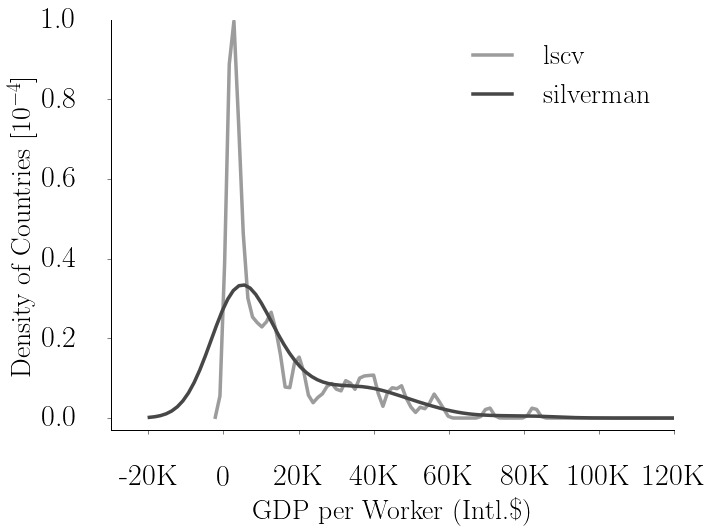

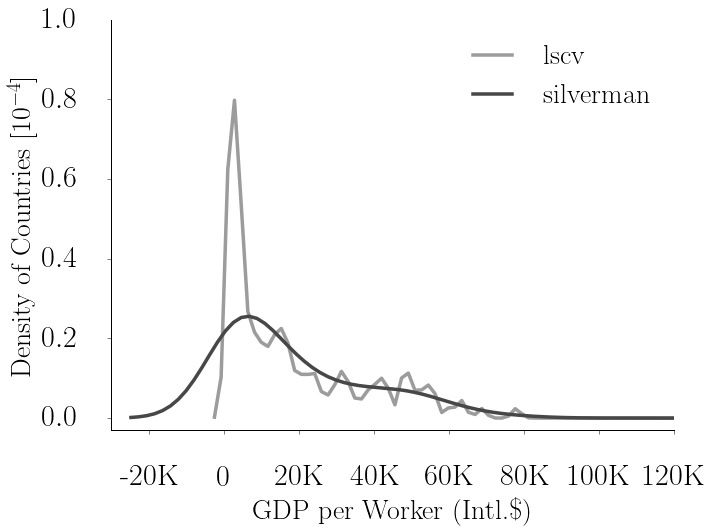

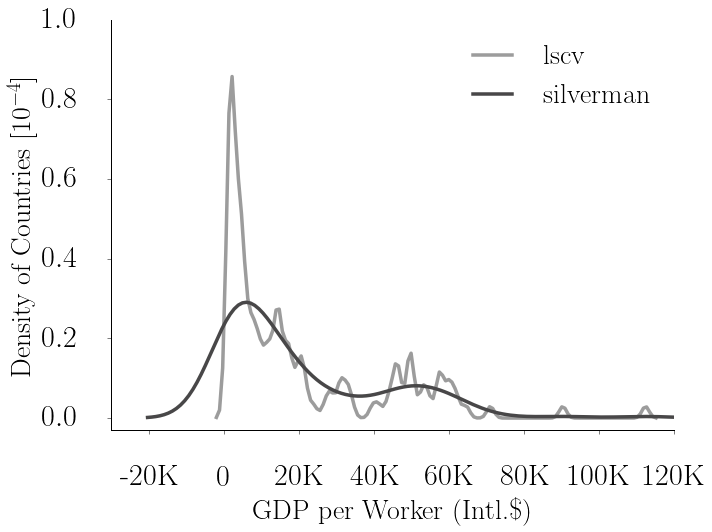

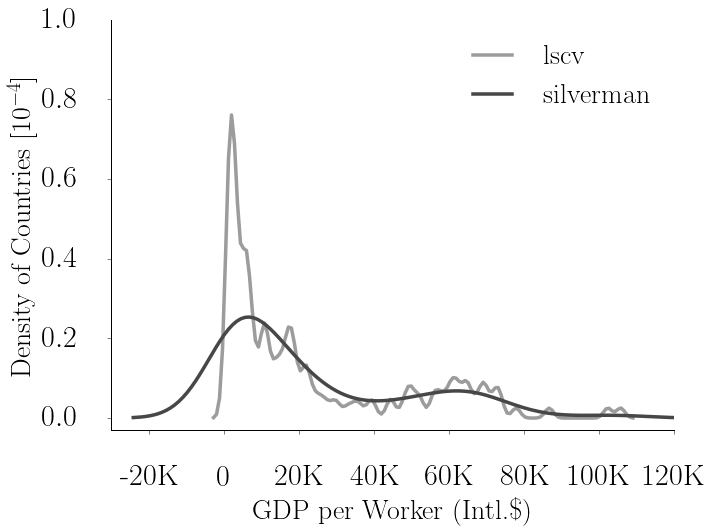

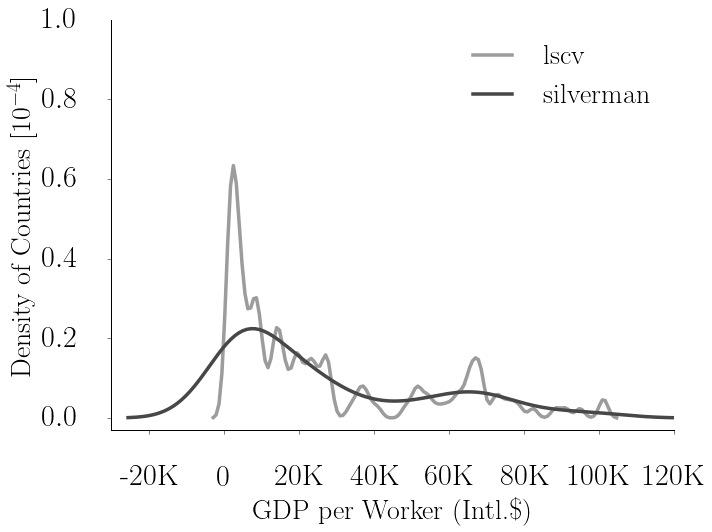

In [5]:
# Loop over all years and the specified bandwidth selection
# methods to plot estimated densities.
for year in [1970, 1980, 1990, 2000, 2010]:
    # Create figure.
    fig, ax = plt.subplots(
        figsize=(plot_params['figure_width'], plot_params['figure_height'])
    )

    for method in sorted(estimated_densities_unweighted[year].keys()):
        # Use latex font.
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
        rc('text', usetex=True)

        # Create plot.
        ax.plot(
            estimated_densities_unweighted[year][method]['support'],
            estimated_densities_unweighted[year][method]['density'],
            color=plot_params['colour_bw'][method],
            label=method,
            linewidth=plot_params['line_width']
        )

        # Set axis limits.
        ax.set_xlim([-30000, 120000])
        ax.set_ylim([-0.000003, 0.0001])

        # Set axis labels.
        ax.set_xlabel(
            'GDP per Worker (Intl.\$)',
            fontsize=plot_params['font_size_labels']
        )
        ax.set_ylabel(
            'Density of Countries [$10^{{-4}}$]',
            fontsize=plot_params['font_size_labels']
        )

        # Set axis ticks and tick labels.
        plt.xticks(
            [-20000, 0, 20000, 40000, 60000, 80000, 100000, 120000],
            ['-20K', '0', '20K', '40K', '60K', '80K', '100K', '120K']
        )
        ax.tick_params(
            axis='x', labelsize=plot_params['font_size_ticks'], direction='out'
        )
        ax.tick_params(
            axis='y', labelsize=plot_params['font_size_ticks'], direction='out'
        )

        # Use scientific notation for y axis.
        yfm = ax.yaxis.get_major_formatter()
        yfm.set_powerlimits([-4, 4])
        offset = ax.get_yaxis().get_offset_text()
        offset.set_visible(False)

        # Remove frame.
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # Add a legend.
        ax.legend(fontsize=plot_params['font_size_legend'], frameon=False)

        # Add a year as title.
        # plt.title(year, fontsize=plot_params['title_size'])

    # Remove whitespace around figure.
    plt.tight_layout()

#### Effects of weights

The following graph allows to analyse the development of dingle countries. These development of the countries will be compared to the weighted gsp results to show how weights mask the effect of growing inequality.

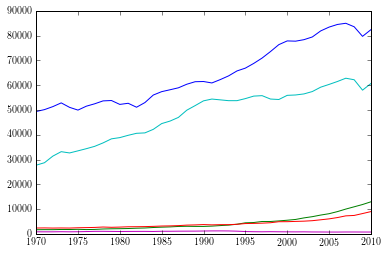

In [6]:
plt.plot(data[data['isocode'] == 'USA'].year, data[data['isocode'] == 'USA'].rgdpwok)
plt.plot(data[data['isocode'] == 'CH2'].year, data[data['isocode'] == 'CH2'].rgdpwok)
plt.plot(data[data['isocode'] == 'IND'].year, data[data['isocode'] == 'IND'].rgdpwok)
plt.plot(data[data['isocode'] == 'JPN'].year, data[data['isocode'] == 'JPN'].rgdpwok)
plt.plot(data[data['isocode'] == 'BDI'].year, data[data['isocode'] == 'BDI'].rgdpwok)
plt.plot(data[data['isocode'] == 'SIL'].year, data[data['isocode'] == 'SIL'].rgdpwok)

## Weighted International Inequality

### Data

In [7]:
# Define weights.
data['pop_weights']=data['POP']/pop_incl

# Add weighted GDP per worker to data set.
data['weighted_rgdpwok'] = data['pop_weights']*data['rgdpwok']

### Analysis

In [8]:
# Specify bandwidth selection methods to be used in estimation.
bw_methods = ['lscv']

# Estimate the densities for the different years and bandwidth selection
# methods.
estimated_densities_weighted = {}

for year in years:
    # Create dictionary entry for year.
    estimated_densities_weighted[year] = {}

    # Restrict data to specified year.
    data_weighted_yearly = data[data['year'] == year].weighted_rgdpwok

    # Initialise the kernel density estimator.
    kde = UnivariateKernelDensity(data=data_weighted_yearly)

    for bandwidth in sorted(bw_methods):
        kde(bandwidth, stretch=2.9)

        # Save the estimated density and corresponding support in dictionary
        estimated_densities_weighted[year][bandwidth] = {
            'support': list(kde.support),
            'density': list(kde.estimated_density)
        }

### Visualisation

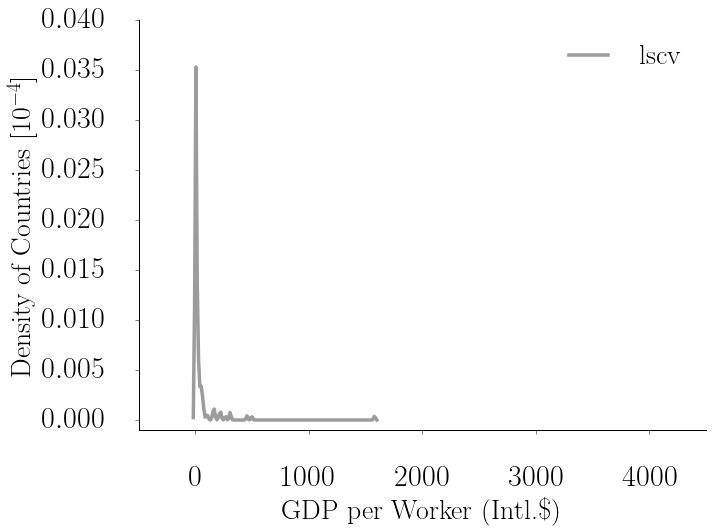

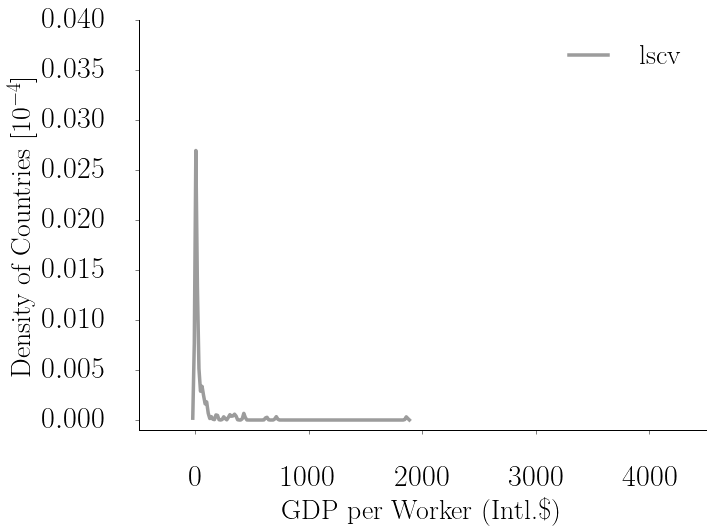

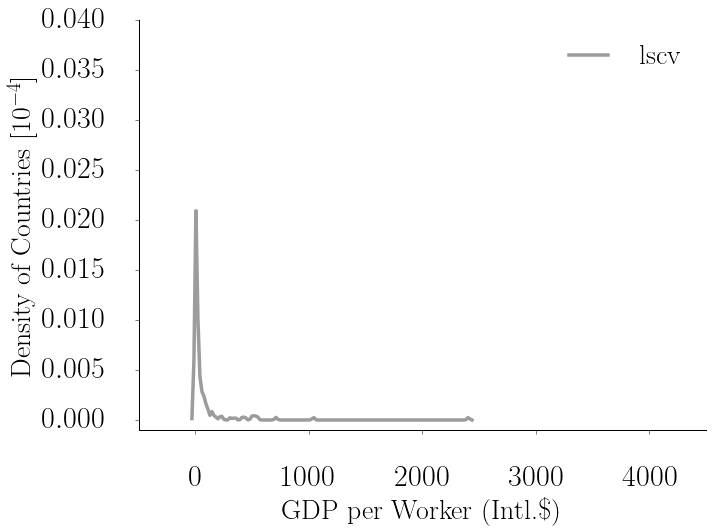

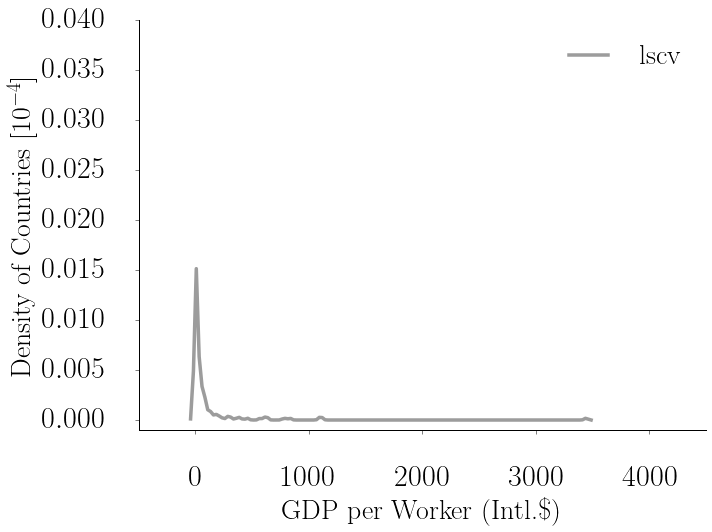

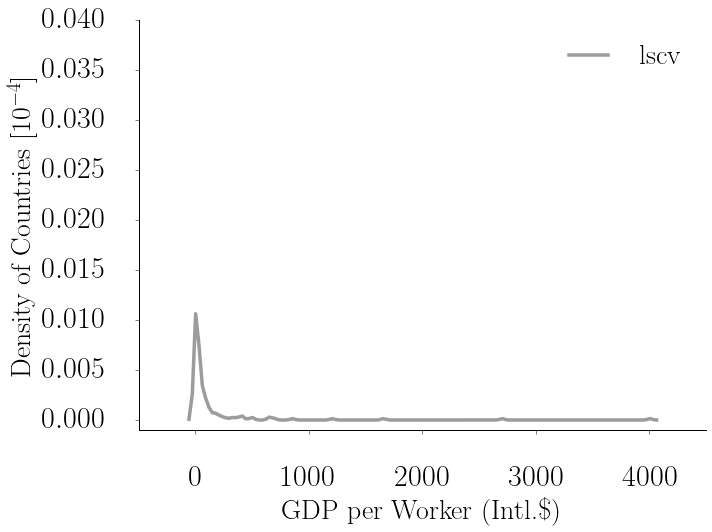

In [9]:
# Loop over all years and the specified bandwidth selection
# methods to plot estimated densities.
for year in [1970, 1980, 1990, 2000, 2010]:
    # Create figure.
    fig, ax = plt.subplots(
        figsize=(plot_params['figure_width'], plot_params['figure_height'])
    )

    for method in sorted(estimated_densities_weighted[year].keys()):
        # Use latex font.
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
        rc('text', usetex=True)

        # Create plot.
        ax.plot(
            estimated_densities_weighted[year][method]['support'],
            estimated_densities_weighted[year][method]['density'],
            color=plot_params['colour_bw'][method],
            label=method,
            linewidth=plot_params['line_width']
        )

        # Set axis limits.
        ax.set_xlim([-500, 4500])
        ax.set_ylim([-0.001, 0.04])

        # Set axis labels.
        ax.set_xlabel(
            'GDP per Worker (Intl.\$)',
            fontsize=plot_params['font_size_labels']
        )
        ax.set_ylabel(
            'Density of Countries [$10^{{-4}}$]',
            fontsize=plot_params['font_size_labels']
        )

        # Set axis ticks and tick labels.
        #plt.xticks(
        #    [-20000, 0, 20000, 40000, 60000, 80000, 100000, 120000],
        #    ['-20K', '0', '20K', '40K', '60K', '80K', '100K', '120K']
        #)
        ax.tick_params(
            axis='x', labelsize=plot_params['font_size_ticks'], direction='out'
        )
        ax.tick_params(
            axis='y', labelsize=plot_params['font_size_ticks'], direction='out'
        )

        # Use scientific notation for y axis.
        yfm = ax.yaxis.get_major_formatter()
        yfm.set_powerlimits([-4, 4])
        offset = ax.get_yaxis().get_offset_text()
        offset.set_visible(False)

        # Remove frame.
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # Add a legend.
        ax.legend(fontsize=plot_params['font_size_legend'], frameon=False)

        # Add a year as title.
        # plt.title(year, fontsize=plot_params['title_size'])

    # Remove whitespace around figure.
    plt.tight_layout()

#### Effects of weights

In [10]:
data[data['weighted_rgdpwok'] >= 1000].isocode.unique()

array(['CH2', 'IND', 'JPN', 'USA'], dtype=object)

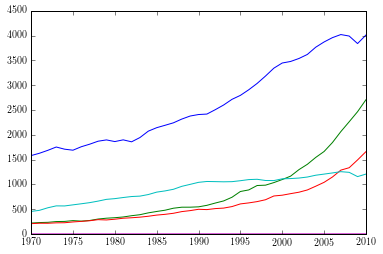

In [11]:
plt.plot(data[data['isocode'] == 'USA'].year, data[data['isocode'] == 'USA'].weighted_rgdpwok)
plt.plot(data[data['isocode'] == 'CH2'].year, data[data['isocode'] == 'CH2'].weighted_rgdpwok)
plt.plot(data[data['isocode'] == 'IND'].year, data[data['isocode'] == 'IND'].weighted_rgdpwok)
plt.plot(data[data['isocode'] == 'JPN'].year, data[data['isocode'] == 'JPN'].weighted_rgdpwok)
plt.plot(data[data['isocode'] == 'BDI'].year, data[data['isocode'] == 'BDI'].weighted_rgdpwok)
plt.plot(data[data['isocode'] == 'SIL'].year, data[data['isocode'] == 'SIL'].weighted_rgdpwok)

In [12]:
data[data['isocode'] == 'USA']['weighted_rgdpwok']

11061    1580.060370
11062    1627.120325
11063    1686.070110
11064    1752.707281
11065    1708.802070
11066    1688.493843
11067    1758.624127
11068    1809.776478
11069    1869.765998
11070    1895.863359
11071    1862.406677
11072    1897.032801
11073    1857.386334
11074    1943.435371
11075    2072.569806
11076    2142.118619
11077    2190.639669
11078    2240.332625
11079    2315.949728
11080    2377.374176
11081    2407.532554
11082    2416.882876
11083    2505.047154
11084    2599.736223
11085    2713.893351
11086    2793.709304
11087    2906.709668
11088    3034.311551
11089    3183.128858
11090    3342.444744
11091    3446.345466
11092    3477.271852
11093    3537.715201
11094    3618.616555
11095    3764.518126
11096    3870.539931
11097    3957.723432
11098    4019.939501
11099    3989.958403
11100    3838.407002
11101    4009.333186
Name: weighted_rgdpwok, dtype: float64

The results show that employing population weights masks the effect of growing inequality. The graphs on country specific developments show the effect of large populations on the time series. 

## GDP per Capita

In [13]:
# Specify bandwidth selection methods to be used in estimation.
bw_methods = ['lscv', 'silverman']

# Estimate the densities for the different years and bandwidth selection
# methods.
estimated_densities_capita = {}

for year in years:
    # Create dictionary entry for year.
    estimated_densities_capita[year] = {}

    # Restrict data to specified year.
    data_capita_yearly = data[data['year'] == year].rgdpch

    # Initialise the kernel density estimator.
    kde = UnivariateKernelDensity(data=data_capita_yearly)

    for bandwidth in sorted(bw_methods):
        kde(bandwidth, stretch=2.9)

        # Save the estimated density and corresponding support in dictionary
        estimated_densities_capita[year][bandwidth] = {
            'support': list(kde.support),
            'density': list(kde.estimated_density)
        }

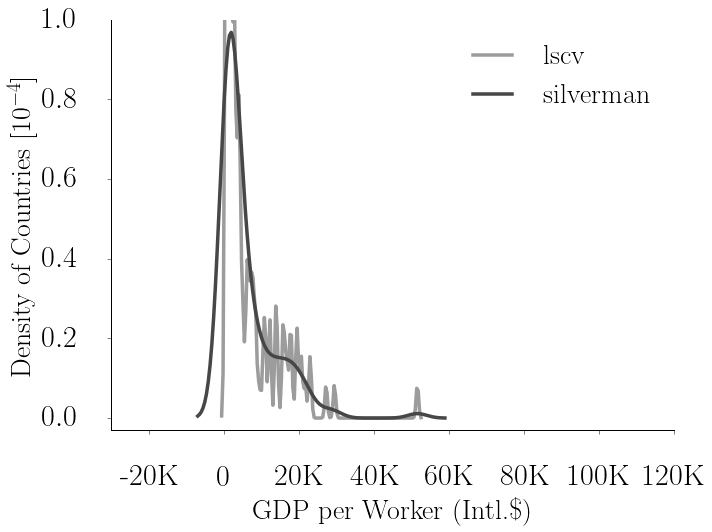

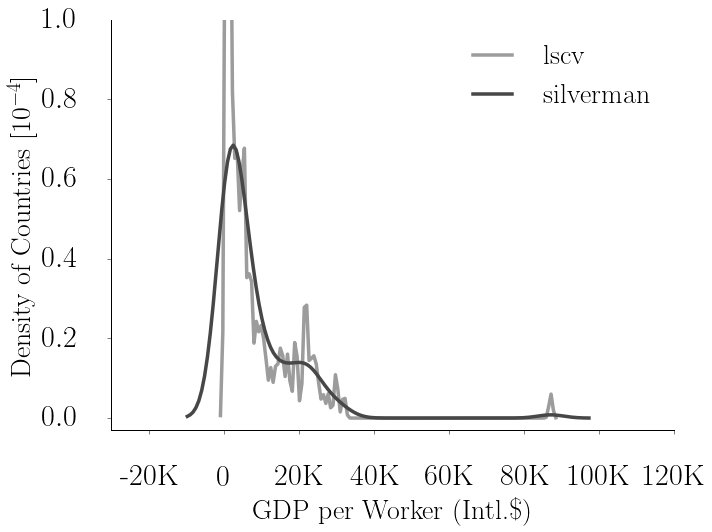

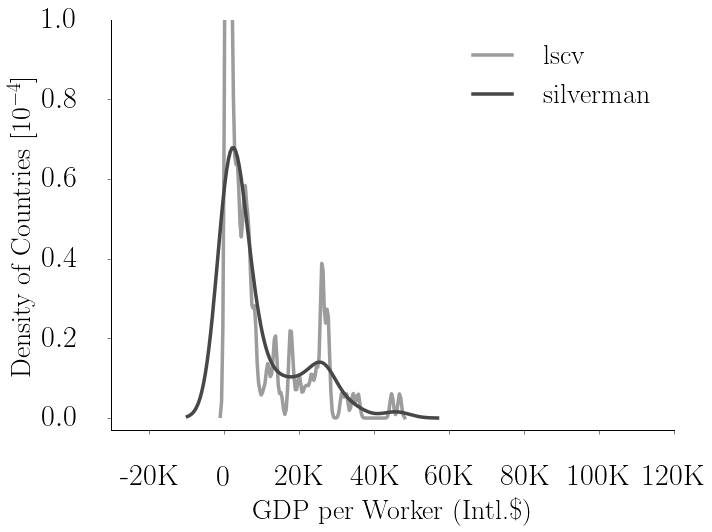

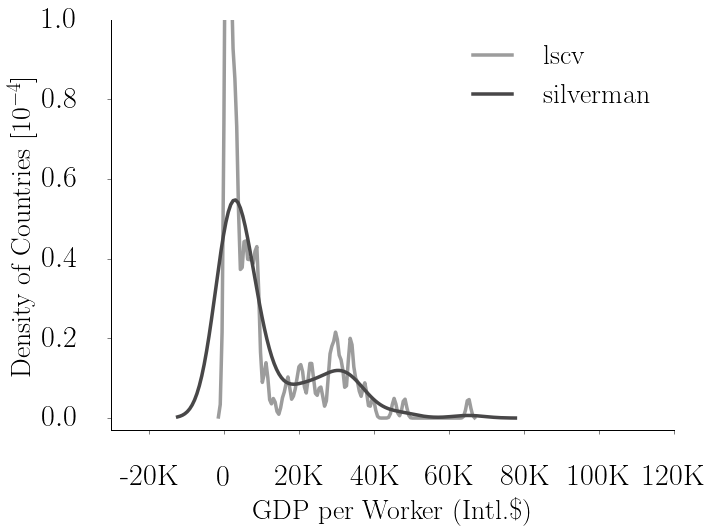

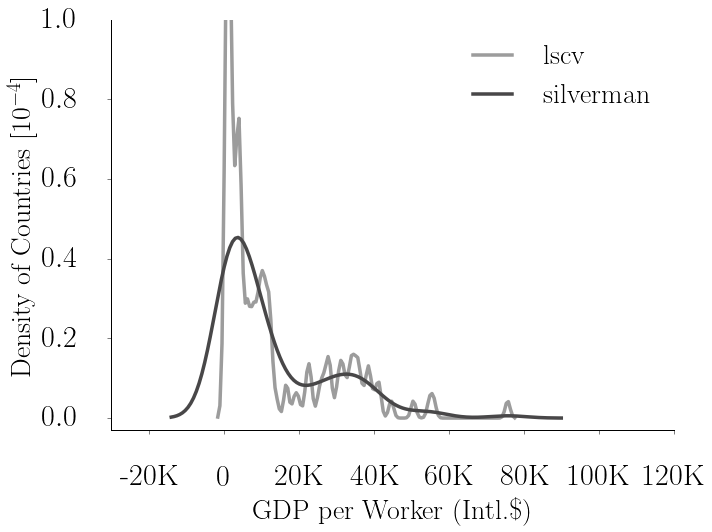

In [14]:
# Loop over all years and the specified bandwidth selection
# methods to plot estimated densities.
for year in [1970, 1980, 1990, 2000, 2010]:
    # Create figure.
    fig, ax = plt.subplots(
        figsize=(plot_params['figure_width'], plot_params['figure_height'])
    )

    for method in sorted(estimated_densities_capita[year].keys()):
        # Use latex font.
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
        rc('text', usetex=True)

        # Create plot.
        ax.plot(
            estimated_densities_capita[year][method]['support'],
            estimated_densities_capita[year][method]['density'],
            color=plot_params['colour_bw'][method],
            label=method,
            linewidth=plot_params['line_width']
        )

        # Set axis limits.
        ax.set_xlim([-30000, 120000])
        ax.set_ylim([-0.000003, 0.0001])

        # Set axis labels.
        ax.set_xlabel(
            'GDP per Worker (Intl.\$)',
            fontsize=plot_params['font_size_labels']
        )
        ax.set_ylabel(
            'Density of Countries [$10^{{-4}}$]',
            fontsize=plot_params['font_size_labels']
        )

        # Set axis ticks and tick labels.
        plt.xticks(
            [-20000, 0, 20000, 40000, 60000, 80000, 100000, 120000],
            ['-20K', '0', '20K', '40K', '60K', '80K', '100K', '120K']
        )
        ax.tick_params(
            axis='x', labelsize=plot_params['font_size_ticks'], direction='out'
        )
        ax.tick_params(
            axis='y', labelsize=plot_params['font_size_ticks'], direction='out'
        )

        # Use scientific notation for y axis.
        yfm = ax.yaxis.get_major_formatter()
        yfm.set_powerlimits([-4, 4])
        offset = ax.get_yaxis().get_offset_text()
        offset.set_visible(False)

        # Remove frame.
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # Add a legend.
        ax.legend(fontsize=plot_params['font_size_legend'], frameon=False)

        # Add a year as title.
        # plt.title(year, fontsize=plot_params['title_size'])

    # Remove whitespace around figure.
    plt.tight_layout()

The graph shows that the development of GDP per capita is very similar to the observations by Kuhlen(2016).

### Logarithm Charpentier

In many applications to income data, the variables are transformed to 

In [15]:
data['log_rgdpch'] = np.log(data['rgdpch'])
data['log_rgdpwok'] = np.log(data['rgdpwok'])

In [16]:
data

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok
20,AFG,1970,3753.620922,12430.623,1041.175816,0.001951,7.321755,6.948106,8.230476
21,AFG,1971,3549.145425,12749.385,982.575564,0.002001,7.100435,6.890177,8.174462
22,AFG,1972,3367.155077,13079.460,930.405334,0.002052,6.910744,6.835620,8.121823
23,AFG,1973,3611.186351,13421.301,995.919603,0.002106,7.605301,6.903667,8.191792
24,AFG,1974,3852.836342,13772.076,1060.519461,0.002161,8.326297,6.966514,8.256565
25,AFG,1975,3968.440861,14132.019,1090.234899,0.002218,8.800271,6.994148,8.286129
26,AFG,1976,4256.599761,14501.369,1167.141336,0.002276,9.685983,7.062313,8.356226
27,AFG,1977,4293.200091,14880.372,1174.899191,0.002335,10.024595,7.068938,8.364788
28,AFG,1978,4425.726163,15269.281,1208.818846,0.002396,10.604130,7.097399,8.395190
29,AFG,1979,4222.052576,15555.612,1150.948497,0.002441,10.305822,7.048342,8.348077


In [17]:
# Specify bandwidth selection methods to be used in estimation.
bw_methods = ['lscv', 'silverman']

# Estimate the densities for the different years and bandwidth selection
# methods.
estimated_densities_log = {}

for year in years:
    # Create dictionary entry for year.
    estimated_densities_log[year] = {}

    # Restrict data to specified year.
    data_capita_yearly = data[data['year'] == year].rgdpwok

    # Initialise the kernel density estimator.
    kde = UnivariateKernelDensity(data=data_capita_yearly, kernel="log_gaussian")

    for bandwidth in sorted(bw_methods):
        kde(bandwidth, stretch=2.9)

        # Save the estimated density and corresponding support in dictionary
        estimated_densities_log[year][bandwidth] = {
            'support': list(kde.support),
            'density': list(kde.estimated_density)
        }

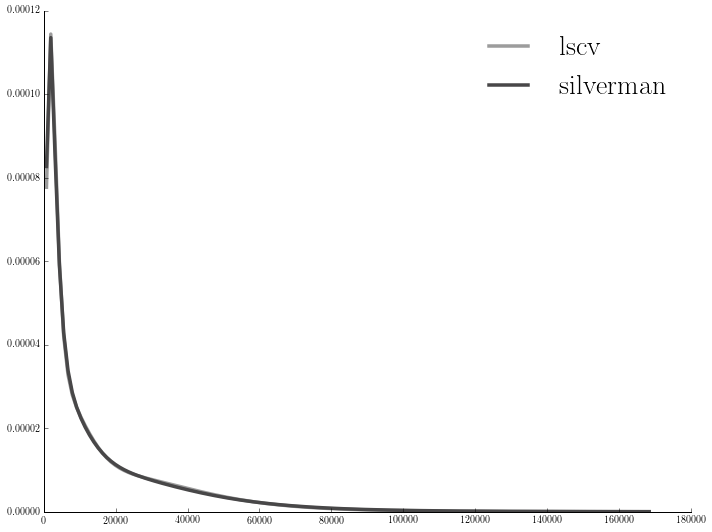

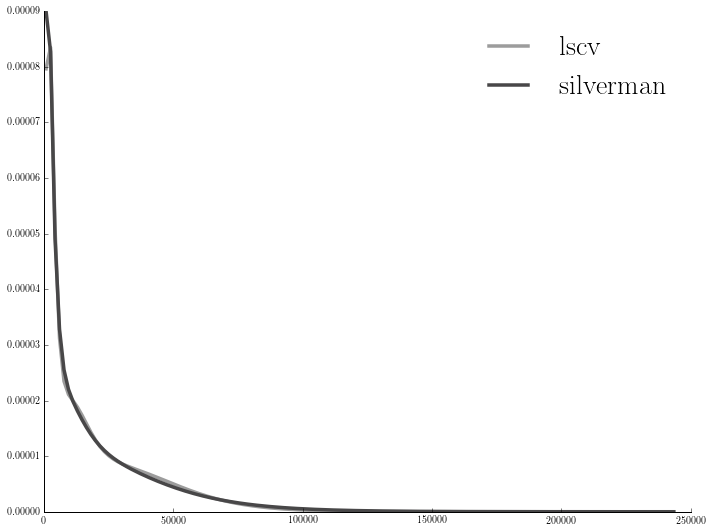

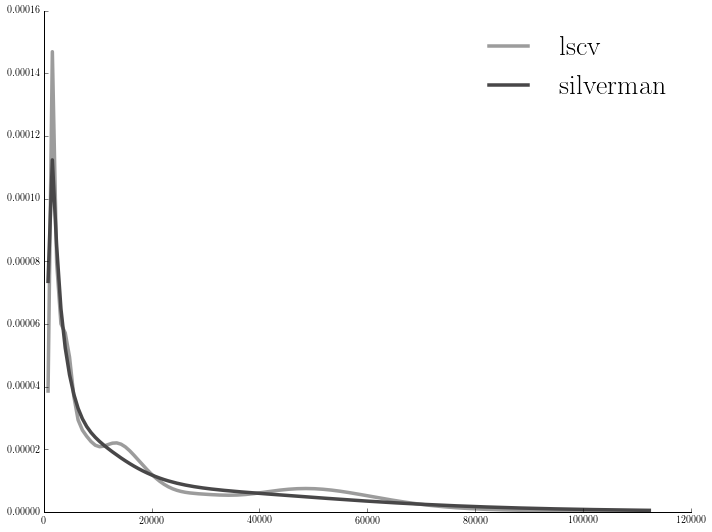

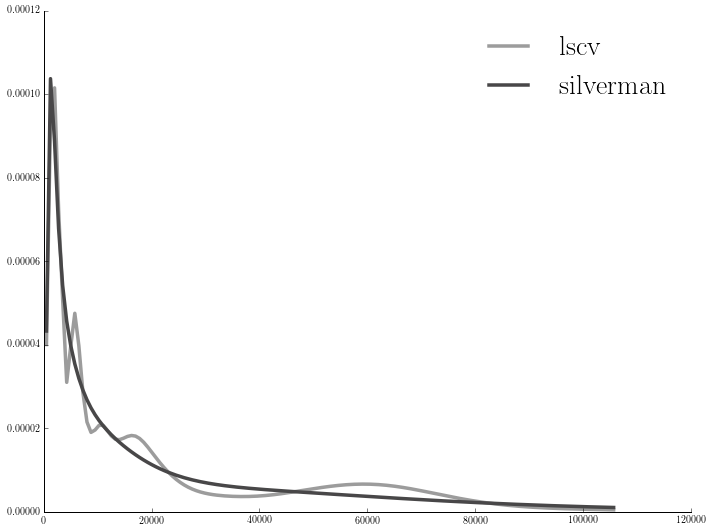

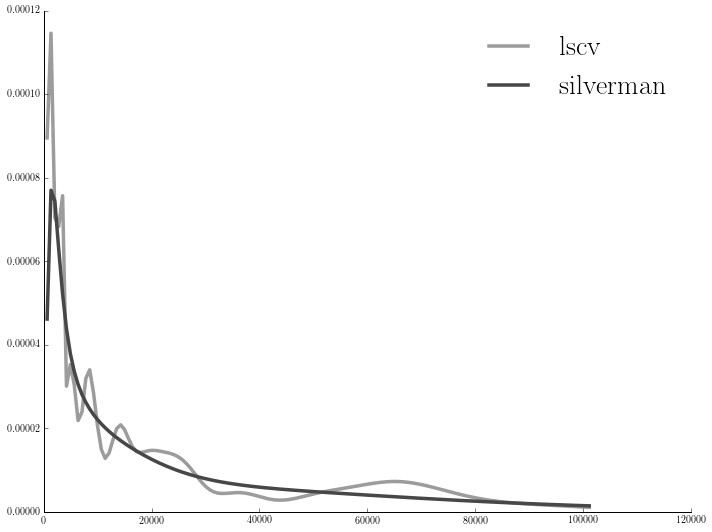

In [18]:
estimated_densities = estimated_densities_log
# Loop over all years and the specified bandwidth selection
# methods to plot estimated densities.
for year in [1970, 1980, 1990, 2000, 2010]:
    # Create figure.
    fig, ax = plt.subplots(
        figsize=(plot_params['figure_width'], plot_params['figure_height'])
    )

    for method in sorted(estimated_densities[year].keys()):
        # Use latex font.
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
        rc('text', usetex=True)

        # Create plot.
        ax.plot(
            estimated_densities[year][method]['support'],
            estimated_densities[year][method]['density'],
            color=plot_params['colour_bw'][method],
            label=method,
            linewidth=plot_params['line_width']
        )

        # Remove frame.
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # Add a legend.
        ax.legend(fontsize=plot_params['font_size_legend'], frameon=False)

        # Add a year as title.
        # plt.title(year, fontsize=plot_params['title_size'])

    # Remove whitespace around figure.
    plt.tight_layout()

In [19]:
weights = {}

In [20]:
for year in years:
    weights[year] = {}
    weights[year] = sum(data[(data['year'] == year)]['POP'])


In [21]:
# sum(weights[1998])

In [22]:
weights

{1970: 3371951.7020000005,
 1971: 3445496.1819999982,
 1972: 3517617.7699999996,
 1973: 3588885.1710000001,
 1974: 3659171.4859999996,
 1975: 3727312.7360000005,
 1976: 3794028.8409999982,
 1977: 3861460.8010000009,
 1978: 3929001.8939999994,
 1979: 3999246.9560000012,
 1980: 4066873.6790000009,
 1981: 4144914.6699999995,
 1982: 4220064.9110000012,
 1983: 4296050.1430000011,
 1984: 4371042.129999999,
 1985: 4447388.9960000012,
 1986: 4526120.6140000019,
 1987: 4607382.4229999995,
 1988: 4689331.2690000013,
 1989: 4771706.7210000008,
 1990: 4854543.0410000021,
 1991: 4934722.8749999981,
 1992: 5015535.029000002,
 1993: 5094774.7360000005,
 1994: 5172765.0139999995,
 1995: 5251103.0020000003,
 1996: 5328933.0389999999,
 1997: 5405300.0900000008,
 1998: 5480758.2090000026,
 1999: 5555678.2279999983,
 2000: 5630121.5340000018,
 2001: 5704610.871000004,
 2002: 5778865.0999999987,
 2003: 5852577.9040000001,
 2004: 5926335.6949999975,
 2005: 6000241.9379999992,
 2006: 6074827.0779999979,
 200

In [23]:
data['tot_pop'] = data['year']

In [24]:
data

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok,tot_pop
20,AFG,1970,3753.620922,12430.623,1041.175816,0.001951,7.321755,6.948106,8.230476,1970
21,AFG,1971,3549.145425,12749.385,982.575564,0.002001,7.100435,6.890177,8.174462,1971
22,AFG,1972,3367.155077,13079.460,930.405334,0.002052,6.910744,6.835620,8.121823,1972
23,AFG,1973,3611.186351,13421.301,995.919603,0.002106,7.605301,6.903667,8.191792,1973
24,AFG,1974,3852.836342,13772.076,1060.519461,0.002161,8.326297,6.966514,8.256565,1974
25,AFG,1975,3968.440861,14132.019,1090.234899,0.002218,8.800271,6.994148,8.286129,1975
26,AFG,1976,4256.599761,14501.369,1167.141336,0.002276,9.685983,7.062313,8.356226,1976
27,AFG,1977,4293.200091,14880.372,1174.899191,0.002335,10.024595,7.068938,8.364788,1977
28,AFG,1978,4425.726163,15269.281,1208.818846,0.002396,10.604130,7.097399,8.395190,1978
29,AFG,1979,4222.052576,15555.612,1150.948497,0.002441,10.305822,7.048342,8.348077,1979


In [25]:
data = data.replace({"tot_pop": weights})

In [26]:
data

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok,tot_pop
20,AFG,1970,3753.620922,12430.623,1041.175816,0.001951,7.321755,6.948106,8.230476,3371951.702
21,AFG,1971,3549.145425,12749.385,982.575564,0.002001,7.100435,6.890177,8.174462,3445496.182
22,AFG,1972,3367.155077,13079.460,930.405334,0.002052,6.910744,6.835620,8.121823,3517617.770
23,AFG,1973,3611.186351,13421.301,995.919603,0.002106,7.605301,6.903667,8.191792,3588885.171
24,AFG,1974,3852.836342,13772.076,1060.519461,0.002161,8.326297,6.966514,8.256565,3659171.486
25,AFG,1975,3968.440861,14132.019,1090.234899,0.002218,8.800271,6.994148,8.286129,3727312.736
26,AFG,1976,4256.599761,14501.369,1167.141336,0.002276,9.685983,7.062313,8.356226,3794028.841
27,AFG,1977,4293.200091,14880.372,1174.899191,0.002335,10.024595,7.068938,8.364788,3861460.801
28,AFG,1978,4425.726163,15269.281,1208.818846,0.002396,10.604130,7.097399,8.395190,3929001.894
29,AFG,1979,4222.052576,15555.612,1150.948497,0.002441,10.305822,7.048342,8.348077,3999246.956


In [27]:
data['pop_weights'] = data['POP'] / data['tot_pop']
  

In [28]:
data

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok,tot_pop
20,AFG,1970,3753.620922,12430.623,1041.175816,0.003686,7.321755,6.948106,8.230476,3371951.702
21,AFG,1971,3549.145425,12749.385,982.575564,0.003700,7.100435,6.890177,8.174462,3445496.182
22,AFG,1972,3367.155077,13079.460,930.405334,0.003718,6.910744,6.835620,8.121823,3517617.770
23,AFG,1973,3611.186351,13421.301,995.919603,0.003740,7.605301,6.903667,8.191792,3588885.171
24,AFG,1974,3852.836342,13772.076,1060.519461,0.003764,8.326297,6.966514,8.256565,3659171.486
25,AFG,1975,3968.440861,14132.019,1090.234899,0.003791,8.800271,6.994148,8.286129,3727312.736
26,AFG,1976,4256.599761,14501.369,1167.141336,0.003822,9.685983,7.062313,8.356226,3794028.841
27,AFG,1977,4293.200091,14880.372,1174.899191,0.003854,10.024595,7.068938,8.364788,3861460.801
28,AFG,1978,4425.726163,15269.281,1208.818846,0.003886,10.604130,7.097399,8.395190,3929001.894
29,AFG,1979,4222.052576,15555.612,1150.948497,0.003890,10.305822,7.048342,8.348077,3999246.956


In [29]:
data['weighted_rgdpwok'] = data['rgdpwok'] * data['pop_weights']

In [30]:
data

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok,tot_pop
20,AFG,1970,3753.620922,12430.623,1041.175816,0.003686,13.837638,6.948106,8.230476,3371951.702
21,AFG,1971,3549.145425,12749.385,982.575564,0.003700,13.132919,6.890177,8.174462,3445496.182
22,AFG,1972,3367.155077,13079.460,930.405334,0.003718,12.519999,6.835620,8.121823,3517617.770
23,AFG,1973,3611.186351,13421.301,995.919603,0.003740,13.504700,6.903667,8.191792,3588885.171
24,AFG,1974,3852.836342,13772.076,1060.519461,0.003764,14.500975,6.966514,8.256565,3659171.486
25,AFG,1975,3968.440861,14132.019,1090.234899,0.003791,15.046251,6.994148,8.286129,3727312.736
26,AFG,1976,4256.599761,14501.369,1167.141336,0.003822,16.269387,7.062313,8.356226,3794028.841
27,AFG,1977,4293.200091,14880.372,1174.899191,0.003854,16.544105,7.068938,8.364788,3861460.801
28,AFG,1978,4425.726163,15269.281,1208.818846,0.003886,17.199701,7.097399,8.395190,3929001.894
29,AFG,1979,4222.052576,15555.612,1150.948497,0.003890,16.422245,7.048342,8.348077,3999246.956


In [31]:
# Calculate total population.
population = {}
for year in years:
    population[year] = {}
    population[year] = sum(data[(data['year'] == year)]['POP'])

# Create new column in data frame containing the total population for a given
# year.
data['tot_pop'] = data['year']
data = data.replace({'tot_pop': population})

# Calculate weights.
data['pop_weights'] = data['POP'] / data['tot_pop']

# Add weighted GDP per worker to data set.
data['weighted_rgdpwok'] = data['rgdpwok'] * data['pop_weights']

In [32]:
data

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok,tot_pop
20,AFG,1970,3753.620922,12430.623,1041.175816,0.003686,13.837638,6.948106,8.230476,3371951.702
21,AFG,1971,3549.145425,12749.385,982.575564,0.003700,13.132919,6.890177,8.174462,3445496.182
22,AFG,1972,3367.155077,13079.460,930.405334,0.003718,12.519999,6.835620,8.121823,3517617.770
23,AFG,1973,3611.186351,13421.301,995.919603,0.003740,13.504700,6.903667,8.191792,3588885.171
24,AFG,1974,3852.836342,13772.076,1060.519461,0.003764,14.500975,6.966514,8.256565,3659171.486
25,AFG,1975,3968.440861,14132.019,1090.234899,0.003791,15.046251,6.994148,8.286129,3727312.736
26,AFG,1976,4256.599761,14501.369,1167.141336,0.003822,16.269387,7.062313,8.356226,3794028.841
27,AFG,1977,4293.200091,14880.372,1174.899191,0.003854,16.544105,7.068938,8.364788,3861460.801
28,AFG,1978,4425.726163,15269.281,1208.818846,0.003886,17.199701,7.097399,8.395190,3929001.894
29,AFG,1979,4222.052576,15555.612,1150.948497,0.003890,16.422245,7.048342,8.348077,3999246.956


In [33]:
data[data['isocode'] == 'CH2']

,isocode,year,rgdpwok,POP,rgdpch,pop_weights,weighted_rgdpwok,log_rgdpch,log_rgdpwok,tot_pop
2216,CH2,1970,1702.601473,820403.282,818.804914,0.243302,414.246691,6.707846,7.439913,3371951.702
2217,CH2,1971,1737.117461,842455.678,840.815793,0.244509,424.741283,6.734373,7.459982,3445496.182
2218,CH2,1972,1728.485733,863439.051,842.022549,0.245461,424.276365,6.735807,7.455001,3517617.770
2219,CH2,1973,1803.186534,883019.765,884.030125,0.246043,443.661269,6.784491,7.497311,3588885.171
2220,CH2,1974,1785.774709,901318.065,881.057043,0.246318,439.867607,6.781122,7.487608,3659171.486
2221,CH2,1975,1864.881224,917898.537,925.895919,0.246263,459.250905,6.830762,7.530953,3727312.736
2222,CH2,1976,1766.206743,932588.727,882.407249,0.245804,434.141270,6.782654,7.476589,3794028.841
2223,CH2,1977,1828.612669,946093.816,919.282307,0.245009,448.027114,6.823593,7.511313,3861460.801
2224,CH2,1978,1997.865119,958835.162,1010.593063,0.244040,487.559787,6.918293,7.599834,3929001.894
2225,CH2,1979,2080.994370,972136.875,1059.125809,0.243080,505.848072,6.965199,7.640601,3999246.956


In [34]:
data[data['year'] == 1979][['isocode','POP']]

,isocode,POP
29,AFG,15555.612
90,ALB,2617.679
151,DZA,18229.932
212,AGO,6452.546
334,ARG,27901.971
456,AUS,14421.900
517,AUT,7549.425
639,BHS,206.150
700,BHR,336.070
761,BGD,85361.165


In [35]:
data_pwt[data_pwt['year']==1980]['POP']

30        15043.603
91         2671.412
152       18806.061
213        6743.080
274          68.546
335       28369.799
396        3115.289
457       14615.900
518        7549.433
579        6168.536
640         209.760
701         347.568
762       87937.333
823         251.966
884        9643.706
945        9846.800
1006        144.416
1067       3458.062
1128         54.726
1189        446.035
1250       5441.298
1311       4092.000
1372        900.476
1433     123019.627
1494        185.220
1555       8843.528
1616       6318.189
1677       4298.207
1738       6888.522
1799       8762.486
            ...    
9790      19482.451
9851        354.083
9912        611.463
9973       8310.473
10034      6385.229
10095      8752.410
10156     17848.320
10217      3966.425
10278     18665.062
10339     47025.764
10400       557.162
10461      2625.511
10522        91.807
10583      1090.513
10644      6443.183
10705     45047.973
10766      2875.133
10827     12414.719
10888     50046.649


In [39]:
data[data['rgdpwok'] == max(data['rgdpwok'])][['year','isocode','rgdpwok']]

,year,isocode,rgdpwok
1493,1979,BRN,277872.8169


In [41]:
data[data['isocode'] == 'BRN'][['year','isocode','rgdpwok']]

,year,isocode,rgdpwok
1484,1970,BRN,168466.70320
1485,1971,BRN,168508.02340
1486,1972,BRN,178143.23090
1487,1973,BRN,188573.78220
1488,1974,BRN,189814.51070
1489,1975,BRN,194584.14860
1490,1976,BRN,222060.01990
1491,1977,BRN,233645.38810
1492,1978,BRN,237945.24570
1493,1979,BRN,277872.81690


In [9]:
data[data.rgdpwok < 100]

,isocode,year,rgdpwok,POP,rgdpch


### New Data Set